<a id='top'></a>

# Wyscout Data Engineering (for Rangers)
##### Notebook to engineer aggregated player performance data from [Wyscout](https://wyscout.com/)

### By [Edd Webster](https://www.twitter.com/eddwebster)
Notebook first written: 13/08/2021<br>
Notebook last updated: 13/08/2021

![title](../../img/wyscout_logo.png)

___

<a id='sectionintro'></a>

## <a id='import_libraries'>Introduction</a>
This notebook engineers aggregated player performance data from [Wyscout](https://wyscout.com/), using [pandas](http://pandas.pydata.org/) for data manipulation through DataFrames.

For more information about this notebook and the author, I'm available through all the following channels:
*    [eddwebster.com](https://www.eddwebster.com/);
*    edd.j.webster@gmail.com;
*    [@eddwebster](https://www.twitter.com/eddwebster);
*    [linkedin.com/in/eddwebster](https://www.linkedin.com/in/eddwebster/);
*    [github/eddwebster](https://github.com/eddwebster/);
*    [public.tableau.com/profile/edd.webster](https://public.tableau.com/profile/edd.webster);
*    [kaggle.com/eddwebster](https://www.kaggle.com/eddwebster); and
*    [hackerrank.com/eddwebster](https://www.hackerrank.com/eddwebster).

![title](../../img/fifa21eddwebsterbanner.png)

The accompanying GitHub repository for this notebook can be found [here](https://github.com/eddwebster/football_analytics) and a static version of this notebook can be found [here](https://nbviewer.jupyter.org/github/eddwebster/football_analytics/blob/master/notebooks/A%29%20Web%20Scraping/FBref%20Web%20Scraping%20and%20Parsing.ipynb).

___

<a id='sectioncontents'></a>

## <a id='notebook_contents'>Notebook Contents</a>
1.    [Notebook Dependencies](#section1)<br>
2.    [Project Brief](#section2)<br>
3.    [Data Sources](#section3)<br>
      1.    [Data Dictionary](#section3.1)<br>
      2.    [Creating DataFrames](#section3.2)<br>
4.    [Initial Data Engineering and Data Unification](#section4)<br> 
5.    [Initial Data Handling](#section5)<br> 
6.    [Further Data Engineering](#section6)<br>
7.    [Summary](#section7)<br>
8.    [Next Steps](#section8)

___

<a id='section1'></a>

## <a id='#section1'>1. Notebook Dependencies</a>

This notebook was written using [Python 3](https://docs.python.org/3.7/) and requires the following libraries:
*    [`Jupyter notebooks`](https://jupyter.org/) for this notebook environment with which this project is presented;
*    [`NumPy`](http://www.numpy.org/) for multidimensional array computing; and
*    [`pandas`](http://pandas.pydata.org/) for data analysis and manipulation.

All packages used for this notebook except for [`Beautifulsoup`](https://pypi.org/project/beautifulsoup4/) and [`Selenium`](https://www.selenium.dev/) can be obtained by downloading and installing the [Conda](https://anaconda.org/anaconda/conda) distribution, available on all platforms (Windows, Linux and Mac OSX). Step-by-step guides on how to install Anaconda can be found for Windows [here](https://medium.com/@GalarnykMichael/install-python-on-windows-anaconda-c63c7c3d1444) and Mac [here](https://medium.com/@GalarnykMichael/install-python-on-mac-anaconda-ccd9f2014072), as well as in the Anaconda documentation itself [here](https://docs.anaconda.com/anaconda/install/).

### Import Libraries and Modules

In [ ]:
# Python ≥3.5 (ideally)
import platform
import sys, getopt
assert sys.version_info >= (3, 5)
import csv
import os
import re
import random
import glob
from io import BytesIO
from pathlib import Path

# Import Dependencies
%matplotlib inline

# Math Operations
import numpy as np
from math import pi

# Datetime
import datetime
from datetime import date
import time

# Data Preprocessing
import pandas as pd
import pandas_profiling as pp

# Reading directories
import glob
import os

# Working with JSON
import json
from pandas.io.json import json_normalize

# Data Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
import missingno as msno

# Display in Jupyter
from IPython.display import Image, Video, YouTubeVideo
from IPython.core.display import HTML

# Ignore Warnings
import warnings
warnings.filterwarnings(action='ignore', message='^internal gelsd')

print('Setup Complete')

In [ ]:
# Python / module versions used here for reference
print('Python: {}'.format(platform.python_version()))
print('NumPy: {}'.format(np.__version__))
print('pandas: {}'.format(pd.__version__))
print('matplotlib: {}'.format(mpl.__version__))

### Define Filepaths

In [ ]:
# Set up initial paths to subfolders
base_dir = os.path.join('..', '..')
data_dir = os.path.join(base_dir, 'data')
data_dir_wyscout = os.path.join(base_dir, 'data', 'wyscout')
img_dir = os.path.join(base_dir, 'img')
fig_dir = os.path.join(base_dir, 'img', 'fig')

### Notebook Settings

In [ ]:
# Display all columns of displayed pandas DataFrames
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

---

<a id='section2'></a>

## <a id='#section2'>2. Project Brief</a>
This Jupyter notebook engineers aggregated player performance data provided by [Wyscout](), using [pandas](http://pandas.pydata.org/) for data maniuplation through DataFrames.

The output of this notebook is a single CSV file that will be used to create visualisation in Tableau.

---

<a id='section3'></a>

## <a id='#section3'>3. Data Sources</a>

<a id='section3.1'></a>

### <a id='#section3.1'>3.1. Data Dictionary</a>
The raw dataset has one hundred and eighty eight features (columns) with the following definitions and data types:

| Variable     | Data Type    | Description    |
|------|-----|-----|
| `squad`    | object    | Squad name e.g. Arsenal    |
| `players_used`    | float64    | Number of Players used in Games    |
| `possession`    | float64    | Percentage of time with possession of the ball    |

<br>

The features will be cleaned, converted and also additional features will be created in the [Data Engineering](#section4) section (Section 4).

In [ ]:
Player                                  object
Team                                    object
Position                                object
Age                                      int64
Market value                             int64
Contract expires                        object
Matches played                           int64
Minutes played                           int64
Goals                                    int64
xG                                     float64
Assists                                  int64
xA                                     float64
Birth country                           object
Foot                                    object
Height                                   int64
On loan                                 object
Successful defensive actions per 90    float64
Defensive duels per 90                 float64
Defensive duels won, %                 float64
Aerial duels per 90                    float64
Aerial duels won, %                    float64
Sliding tackles per 90                 float64
PAdj Sliding tackles                   float64
Shots blocked per 90                   float64
Interceptions per 90                   float64
PAdj Interceptions                     float64
Fouls per 90                           float64
Yellow cards                             int64
Yellow cards per 90                    float64
Red cards                                int64
Red cards per 90                       float64
Successful attacking actions per 90    float64
Goals per 90                           float64
Non-penalty goals                        int64
Non-penalty goals per 90               float64
xG per 90                              float64
Head goals                               int64
Head goals per 90                      float64
Shots                                    int64
Shots per 90                           float64
Shots on target, %                     float64
Goal conversion, %                     float64
Assists per 90                         float64
Crosses per 90                         float64
Accurate crosses, %                    float64
Dribbles per 90                        float64
Successful dribbles, %                 float64
Offensive duels per 90                 float64
Offensive duels won, %                 float64
Touches in box per 90                  float64
Progressive runs per 90                float64
Accelerations per 90                   float64
Received passes per 90                 float64
Fouls suffered per 90                  float64
Passes per 90                          float64
Accurate passes, %                     float64
Forward passes per 90                  float64
Accurate forward passes, %             float64
Long passes per 90                     float64
Accurate long passes, %                float64
xA per 90                              float64
Shot assists per 90                    float64
Second assists per 90                  float64
Third assists per 90                   float64
Smart passes per 90                    float64
Accurate smart passes, %               float64
Key passes per 90                      float64
Passes to final third per 90           float64
Accurate passes to final third, %      float64
Passes to penalty area per 90          float64
Accurate passes to penalty area, %     float64
Through passes per 90                  float64
Accurate through passes, %             float64
Deep completions per 90                float64
Deep completed crosses per 90          float64
Progressive passes per 90              float64
Accurate progressive passes, %         float64
Free kicks per 90                      float64
Direct free kicks per 90               float64
Direct free kicks on target, %         float64
Corners per 90                         float64
Penalties taken                          int64
Penalty conversion, %                  float64
Season                                  object
League                                  object

<a id='section3.2'></a>

### <a id='#section3.2'>3.2. Creating the DataFrames</a>

In [ ]:
# Read data directory
print(glob.glob(os.path.join(data_dir_wyscout, 'raw/aggregated/*.xlsx')))

In [ ]:
# Import Excel datasets as a pandas DataFrame
df_wyscout_scotland_2021 = pd.read_excel(os.path.join(data_dir_wyscout, 'raw/aggregated/Scotland - 20-21.xlsx'), index_col=None, header=0) 
df_wyscout_scotland_1920 = pd.read_excel(os.path.join(data_dir_wyscout, 'raw/aggregated/Scotland - 19-20.xlsx'), index_col=None, header=0) 
df_wyscout_2bundesliga_2021 = pd.read_excel(os.path.join(data_dir_wyscout, 'raw/aggregated/2Bundesliga - 20-21.xlsx'), index_col=None, header=0) 
df_wyscout_2bundesliga_1920 = pd.read_excel(os.path.join(data_dir_wyscout, 'raw/aggregated/2Bundesliga - 19-20.xlsx'), index_col=None, header=0) 
df_wyscout_belgium_2021 = pd.read_excel(os.path.join(data_dir_wyscout, 'raw/aggregated/Belgium 20-21.xlsx'), index_col=None, header=0) 
df_wyscout_belgium_1920 = pd.read_excel(os.path.join(data_dir_wyscout, 'raw/aggregated/Belgium 19-20.xlsx'), index_col=None, header=0) 

In [ ]:
df_wyscout_scotland_2021.columns

___

<a id='section4'></a>

## <a id='#section4'>4. Initial Data Engineering and Data Unification</a>

<a id='section4.1'></a>

### <a id='#section4.1'>4.1. Add Season Column to Each Dataset</a>

In [ ]:
# Import Excel datasets as a pandas DataFrame
df_wyscout_scotland_2021['Season'] = '20/21'
df_wyscout_scotland_1920['Season'] = '19/20'
df_wyscout_2bundesliga_2021['Season'] = '20/21'
df_wyscout_2bundesliga_1920['Season'] = '19/20'
df_wyscout_belgium_2021['Season'] = '20/21'
df_wyscout_belgium_1920['Season'] = '19/20'

<a id='section4.2'></a>

### <a id='#section4.2'>4.2. Add League Name Column to Each Dataset</a>

In [ ]:
# Import Excel datasets as a pandas DataFrame
df_wyscout_scotland_2021['League'] = 'Scottish Premiership'
df_wyscout_scotland_1920['League'] = 'Scottish Premiership'
df_wyscout_2bundesliga_2021['League'] = '2. Bundesliga'
df_wyscout_2bundesliga_1920['League'] = '2. Bundesliga'
df_wyscout_belgium_2021['League'] = 'Belgian First Division A'
df_wyscout_belgium_1920['League'] = 'Belgian First Division A'

<a id='section4.3'></a>

### <a id='#section4.3'>4.3. Union the Datasets for Individual Seasons</a>

In [ ]:
#

## 
lst_dfs = [df_wyscout_scotland_2021, df_wyscout_scotland_1920, df_wyscout_2bundesliga_2021, df_wyscout_2bundesliga_1920, df_wyscout_belgium_2021, df_wyscout_belgium_1920]

## Union the individual datasets
df_wyscout_raw = pd.concat(lst_dfs)

<a id='section4.4'></a>

### <a id='#section4.4'>4.4. Export Raw Dataset</a>

In [ ]:
# Export DataFrame
df_wyscout_raw.to_csv(os.path.join(data_dir_wyscout, 'raw/aggregated/wyscout_scotland_2bundesliga_belgium_1920_2021.csv'), index=None, header=True)

___

<a id='section5'></a>

## <a id='#section5'>5. Data Handling</a>

<a id='section5.1'></a>

### <a id='#section5.1'>5.1. Summary Report</a>
Initial step of the data handling and Exploratory Data Analysis (EDA) is to create a quick summary report of the dataset using [pandas Profiling Report](https://github.com/pandas-profiling/pandas-profiling).

In [ ]:
# Summary of the data using pandas Profiling Report
pp.ProfileReport(df_wyscout_raw)

<a id='section5.2'></a>

### <a id='#section5.2'>5.2. Further Inspection</a>
The following commands go into more bespoke summary of the dataset. Some of the commands include content covered in the [pandas Profiling](https://github.com/pandas-profiling/pandas-profiling) summary above, but using the standard [pandas](https://pandas.pydata.org/) functions and methods that most peoplem will be more familiar with.

First check the quality of the dataset by looking first and last rows in pandas using the [head()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) and [tail()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.tail.html) methods.

In [13]:
# Display the first five rows of the raw DataFrame, df_wyscout_raw
df_wyscout_raw.head()

,Player,Team,Position,Age,Market value,Contract expires,Matches played,Minutes played,Goals,xG,Assists,xA,Birth country,Foot,Height,On loan,Successful defensive actions per 90,Defensive duels per 90,"Defensive duels won, %",Aerial duels per 90,"Aerial duels won, %",Sliding tackles per 90,PAdj Sliding tackles,Shots blocked per 90,Interceptions per 90,PAdj Interceptions,Fouls per 90,Yellow cards,Yellow cards per 90,Red cards,Red cards per 90,Successful attacking actions per 90,Goals per 90,Non-penalty goals,Non-penalty goals per 90,xG per 90,Head goals,Head goals per 90,Shots,Shots per 90,"Shots on target, %","Goal conversion, %",Assists per 90,Crosses per 90,"Accurate crosses, %",Dribbles per 90,"Successful dribbles, %",Offensive duels per 90,"Offensive duels won, %",Touches in box per 90,Progressive runs per 90,Accelerations per 90,Received passes per 90,Fouls suffered per 90,Passes per 90,"Accurate passes, %",Forward passes per 90,"Accurate forward passes, %",Long passes per 90,"Accurate long passes, %",xA per 90,Shot assists per 90,Second assists per 90,Third assists per 90,Smart passes per 90,"Accurate smart passes, %",Key passes per 90,Passes to final third per 90,"Accurate passes to final third, %",Passes to penalty area per 90,"Accurate passes to penalty area, %",Through passes per 90,"Accurate through passes, %",Deep completions per 90,Deep completed crosses per 90,Progressive passes per 90,"Accurate progressive passes, %",Free kicks per 90,Direct free kicks per 90,"Direct free kicks on target, %",Corners per 90,Penalties taken,"Penalty conversion, %",Season,League
0,O. Édouard,Celtic,CF,23,17000000,2022-05-31,31,2409,18,21.75,4,3.88,French Guiana,right,187,no,2.54,1.94,65.38,3.10,39.76,0.07,0.13,0.11,1.20,2.12,0.64,1,0.04,0,0.0,5.60,0.67,13,0.49,0.81,1,0.04,101,3.77,51.49,17.822,0.15,0.78,28.57,6.87,45.11,16.59,31.53,5.53,1.68,0.64,20.10,1.01,25.29,82.13,4.67,68.80,0.26,42.86,0.15,1.12,0.04,0.00,0.86,39.13,0.56,1.34,80.56,2.54,64.71,0.78,38.10,2.02,0.19,1.64,88.64,0.30,0.30,12.5,0.00,6,83.333,20/21,Scottish Premiership
1,R. Kent,Rangers,"LWF, LAMF",24,14000000,2023-05-31,37,3128,10,7.75,8,6.69,England,right,172,no,4.09,3.63,57.14,2.04,12.68,0.03,0.05,0.03,1.99,3.46,0.75,0,0.00,0,0.0,6.70,0.29,10,0.29,0.22,1,0.03,82,2.36,41.46,12.195,0.23,2.45,43.53,7.88,54.74,14.24,42.42,4.11,3.91,2.79,33.69,1.64,44.19,88.02,8.23,79.37,1.44,50.00,0.19,1.64,0.14,0.09,0.72,48.00,0.95,3.65,85.83,3.34,59.48,0.72,40.00,2.01,1.06,4.92,91.23,0.03,0.00,0.0,0.75,0,0.000,20/21,Scottish Premiership
2,M. Elyounoussi,Southampton,"LAMF, CF, AMF",27,12000000,2023-06-30,34,1868,10,10.53,4,2.70,Norway,right,178,no,6.31,5.40,54.46,5.40,48.21,0.29,0.53,0.19,3.08,5.61,1.54,2,0.10,0,0.0,5.20,0.48,10,0.48,0.51,3,0.14,68,3.28,42.65,14.706,0.19,2.17,28.89,5.06,52.38,13.01,37.04,5.01,2.75,1.16,27.37,0.96,35.94,80.03,8.29,67.44,1.59,48.48,0.13,1.25,0.00,0.00,1.20,44.00,0.67,2.46,66.67,3.66,51.32,1.11,34.78,2.17,0.63,3.47,79.17,0.14,0.05,0.0,0.05,0,0.000,20/21,Scottish Premiership
3,A. Morelos,Rangers,CF,25,12000000,2023-05-31,29,2143,12,13.68,3,2.15,Colombia,left,177,no,3.86,3.74,44.94,3.95,28.72,0.25,0.42,0.04,1.93,3.21,1.76,8,0.34,0,0.0,2.69,0.50,12,0.50,0.57,3,0.13,73,3.07,41.10,16.438,0.13,0.80,31.58,2.65,34.92,9.83,33.76,5.46,0.84,0.46,25.45,1.85,32.17,80.42,4.75,65.49,1.13,74.07,0.09,0.76,0.04,0.04,0.55,46.15,0.29,1.89,71.11,1.26,46.67,0.42,40.00,1.26,0.21,2.02,68.75,0.00,0.00,0.0,0.00,0,0.000,20/21,Scottish Premiership
4,J. Frimpong,Bayer Leverkusen,"RB, RWB",20,10000000,2025-06-30,22,1750,1,1.76,1,3.02,Netherlands,right,175,no,6.07,5.19,66.34,3.65,29.58,0.10,0.19,0.10,2.52,4.54,0.31,0,0.00,0,0.0,4.78,0.05,1,0.05,0.09,0,0.00,14,0.72,42.86,7.143,0.05,2.98,18.97,6.84,54.14,11.78,49.34,3.19,7.20,2.73,32.55,2.01,42.84,84.75,10.03,77.95,1.70,54.55,0.16,1.39,0.05,0.05,0.31,66.67,0.51,3.75,82.19,1.95,55.26,0.26,60.00,1.29,0.57,7.61,72.97,0.00,0.00,0.0,0.00,0,0.000,20/21,Scottish Premiership


In [15]:
# Display the last five rows of the raw DataFrame, df_wyscout_raw
df_wyscout_raw.tail()

,Player,Team,Position,Age,Market value,Contract expires,Matches played,Minutes played,Goals,xG,Assists,xA,Birth country,Foot,Height,On loan,Successful defensive actions per 90,Defensive duels per 90,"Defensive duels won, %",Aerial duels per 90,"Aerial duels won, %",Sliding tackles per 90,PAdj Sliding tackles,Shots blocked per 90,Interceptions per 90,PAdj Interceptions,Fouls per 90,Yellow cards,Yellow cards per 90,Red cards,Red cards per 90,Successful attacking actions per 90,Goals per 90,Non-penalty goals,Non-penalty goals per 90,xG per 90,Head goals,Head goals per 90,Shots,Shots per 90,"Shots on target, %","Goal conversion, %",Assists per 90,Crosses per 90,"Accurate crosses, %",Dribbles per 90,"Successful dribbles, %",Offensive duels per 90,"Offensive duels won, %",Touches in box per 90,Progressive runs per 90,Accelerations per 90,Received passes per 90,Fouls suffered per 90,Passes per 90,"Accurate passes, %",Forward passes per 90,"Accurate forward passes, %",Long passes per 90,"Accurate long passes, %",xA per 90,Shot assists per 90,Second assists per 90,Third assists per 90,Smart passes per 90,"Accurate smart passes, %",Key passes per 90,Passes to final third per 90,"Accurate passes to final third, %",Passes to penalty area per 90,"Accurate passes to penalty area, %",Through passes per 90,"Accurate through passes, %",Deep completions per 90,Deep completed crosses per 90,Progressive passes per 90,"Accurate progressive passes, %",Free kicks per 90,Direct free kicks per 90,"Direct free kicks on target, %",Corners per 90,Penalties taken,"Penalty conversion, %",Season,League
401,E. Asomani,NaN,"RAMF, RW",21,50000,NaN,1,42,0,0.00,0,0.06,Ghana,right,170,no,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,0.00,NaN,0,NaN,0,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,19/20,Belgian First Division A
402,T. Ivanof,NaN,"RAMF, LAMF, RW",24,0,NaN,2,129,0,0.00,1,0.18,Belgium,right,176,no,6.98,7.67,72.73,1.40,50.00,0.70,0.71,0.00,0.70,0.71,0.00,0,0.00,0,0.0,1.40,0.0,0,0.0,0.00,0,0.0,0,0.00,0.0,0.0,0.7,0.70,100.0,2.79,0.00,10.47,13.33,1.40,1.40,2.09,16.05,2.09,23.02,84.85,2.79,50.00,0.00,0.00,0.13,0.70,0.0,0.0,0.70,100.0,0.70,0.00,0.00,0.70,100.00,0.00,0.00,1.40,0.70,2.79,25.00,0.0,0.0,0.0,0.0,0,0.0,19/20,Belgian First Division A
403,S. Mmaee,Ferencváros,"RCB, CB, LCMF",24,0,NaN,22,1954,0,0.66,0,0.09,Belgium,right,188,no,11.24,7.00,69.74,4.28,64.52,0.55,0.76,0.92,5.80,7.94,0.78,3,0.14,0,0.0,0.92,0.0,0,0.0,0.03,0,0.0,8,0.37,12.5,0.0,0.0,0.28,0.0,1.01,72.73,2.86,37.10,0.41,0.69,0.18,29.94,0.41,45.41,87.22,16.54,78.55,4.42,60.42,0.00,0.09,0.0,0.0,0.46,30.0,0.00,4.88,73.58,0.78,23.53,0.41,22.22,0.23,0.00,7.83,70.00,0.0,0.0,0.0,0.0,0,0.0,19/20,Belgian First Division A
404,N. Kainourgios,NaN,LB,22,0,NaN,3,162,0,0.00,0,0.08,Greece,left,187,no,14.44,9.44,70.59,4.44,62.50,1.11,1.94,0.56,6.67,11.61,1.67,0,0.00,0,0.0,3.33,0.0,0,0.0,0.00,0,0.0,0,0.00,0.0,0.0,0.0,5.56,0.0,3.89,71.43,10.56,47.37,1.67,4.44,2.78,31.11,2.22,47.22,74.12,22.78,73.17,5.00,33.33,0.04,0.56,0.0,0.0,0.56,100.0,0.56,7.78,64.29,5.56,10.00,0.00,0.00,0.56,0.56,12.78,56.52,0.0,0.0,0.0,0.0,0,0.0,19/20,Belgian First Division A
405,K. N’Dri,Eupen,"RW, RWF",20,0,2024-06-30,3,46,0,0.00,0,0.24,Côte d'Ivoire,left,174,no,7.83,9.78,60.00,0.00,0.00,1.96,2.14,0.00,0.00,0.00,3.91,0,0.00,0,0.0,11.74,0.0,0,0.0,0.00,0,0.0,0,0.00,0.0,0.0,0.0,3.91,50.0,13.70,71.43,15.65,62.50,0.00,5.87,11.74,17.61,3.91,23.48,75.00,5.87,33.33,0.00,0.00,0.46,1.96,0.0,0.0,1.96,0.0,1.96,1.96,0.00,5.87,33.33,1.96,0.00,0.00,1.96,5.87,100.00,0.0,0.0,0.0,0.0,0,0.0,19/20,Belgian First Division A


[shape](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dtypes.html) returns a tuple representing the dimensionality of the DataFrame.

In [16]:
# Print the shape of the raw DataFrame, df_wyscout_raw
print(df_wyscout_raw.shape)

(2407, 85)


[columns](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.columns.html) returns the column labels of the DataFrame.

In [18]:
# Features (column names) of the raw DataFrame, df_wyscout_raw
df_wyscout_raw.columns

Index(['Player', 'Team', 'Position', 'Age', 'Market value', 'Contract expires',
       'Matches played', 'Minutes played', 'Goals', 'xG', 'Assists', 'xA',
       'Birth country', 'Foot', 'Height', 'On loan',
       'Successful defensive actions per 90', 'Defensive duels per 90',
       'Defensive duels won, %', 'Aerial duels per 90', 'Aerial duels won, %',
       'Sliding tackles per 90', 'PAdj Sliding tackles',
       'Shots blocked per 90', 'Interceptions per 90', 'PAdj Interceptions',
       'Fouls per 90', 'Yellow cards', 'Yellow cards per 90', 'Red cards',
       'Red cards per 90', 'Successful attacking actions per 90',
       'Goals per 90', 'Non-penalty goals', 'Non-penalty goals per 90',
       'xG per 90', 'Head goals', 'Head goals per 90', 'Shots', 'Shots per 90',
       'Shots on target, %', 'Goal conversion, %', 'Assists per 90',
       'Crosses per 90', 'Accurate crosses, %', 'Dribbles per 90',
       'Successful dribbles, %', 'Offensive duels per 90',
       'Offensive d

The [dtypes](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dtypes.html) method returns the data types of each attribute in the DataFrame.

In [19]:
# Data types of the features of the raw DataFrame, df_wyscout_raw
df_wyscout_raw.dtypes

Player                    object
Team                      object
Position                  object
Age                        int64
Market value               int64
                          ...   
Corners per 90           float64
Penalties taken            int64
Penalty conversion, %    float64
Season                    object
League                    object
Length: 85, dtype: object

In [20]:
# Displays all one hundered and four columns
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_wyscout_raw.dtypes)

Player                                  object
Team                                    object
Position                                object
Age                                      int64
Market value                             int64
Contract expires                        object
Matches played                           int64
Minutes played                           int64
Goals                                    int64
xG                                     float64
Assists                                  int64
xA                                     float64
Birth country                           object
Foot                                    object
Height                                   int64
On loan                                 object
Successful defensive actions per 90    float64
Defensive duels per 90                 float64
Defensive duels won, %                 float64
Aerial duels per 90                    float64
Aerial duels won, %                    float64
Sliding tackl

The [info](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.info.html) method to get a quick description of the data, in particular the total number of rows, and each attribute’s type and number of non-null values.

In [21]:
# Info for the raw DataFrame, df_wyscout_raw
df_wyscout_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2407 entries, 0 to 405
Data columns (total 85 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Player                               2407 non-null   object 
 1   Team                                 2270 non-null   object 
 2   Position                             2407 non-null   object 
 3   Age                                  2407 non-null   int64  
 4   Market value                         2407 non-null   int64  
 5   Contract expires                     2147 non-null   object 
 6   Matches played                       2407 non-null   int64  
 7   Minutes played                       2407 non-null   int64  
 8   Goals                                2407 non-null   int64  
 9   xG                                   2407 non-null   float64
 10  Assists                              2407 non-null   int64  
 11  xA                             

The [describe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html) method to show some useful statistics for each numerical column in the DataFrame.

In [22]:
# Description of the raw DataFrame, df_wyscout_raw, showing some summary statistics for each numberical column in the DataFrame
df_wyscout_raw.describe()

,Age,Market value,Matches played,Minutes played,Goals,xG,Assists,xA,Height,Successful defensive actions per 90,Defensive duels per 90,"Defensive duels won, %",Aerial duels per 90,"Aerial duels won, %",Sliding tackles per 90,PAdj Sliding tackles,Shots blocked per 90,Interceptions per 90,PAdj Interceptions,Fouls per 90,Yellow cards,Yellow cards per 90,Red cards,Red cards per 90,Successful attacking actions per 90,Goals per 90,Non-penalty goals,Non-penalty goals per 90,xG per 90,Head goals,Head goals per 90,Shots,Shots per 90,"Shots on target, %","Goal conversion, %",Assists per 90,Crosses per 90,"Accurate crosses, %",Dribbles per 90,"Successful dribbles, %",Offensive duels per 90,"Offensive duels won, %",Touches in box per 90,Progressive runs per 90,Accelerations per 90,Received passes per 90,Fouls suffered per 90,Passes per 90,"Accurate passes, %",Forward passes per 90,"Accurate forward passes, %",Long passes per 90,"Accurate long passes, %",xA per 90,Shot assists per 90,Second assists per 90,Third assists per 90,Smart passes per 90,"Accurate smart passes, %",Key passes per 90,Passes to final third per 90,"Accurate passes to final third, %",Passes to penalty area per 90,"Accurate passes to penalty area, %",Through passes per 90,"Accurate through passes, %",Deep completions per 90,Deep completed crosses per 90,Progressive passes per 90,"Accurate progressive passes, %",Free kicks per 90,Direct free kicks per 90,"Direct free kicks on target, %",Corners per 90,Penalties taken,"Penalty conversion, %"
count,2407.000000,2.407000e+03,2407.000000,2407.000000,2407.000000,2407.000000,2407.00000,2407.000000,2407.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2407.000000,2240.000000,2240.000000,2407.000000,2240.000000,2407.000000,2240.000000,2407.000000,2240.000000,2240.000000,2240.000000,2407.000000,2240.000000,2240.000000,2407.000000,2240.000000,2407.000000,2240.000000,2240.000000,2407.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.00000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2064.000000,2064.000000,2064.000000,2240.000000,2407.000000,2407.000000
mean,25.340673,1.413513e+06,16.752804,1212.791857,1.624844,1.721948,0.97715,1.031994,178.876194,7.584496,5.902027,56.004281,4.053040,44.560732,0.401982,0.527270,0.222379,3.726219,4.986996,1.226848,2.086830,0.164844,0.119236,0.011205,2.384902,0.115692,1.479020,0.107969,0.133259,0.288741,0.019348,14.062734,1.089893,28.447272,7.571428,0.067955,1.432339,26.508058,2.618063,49.665330,6.464509,41.688540,1.609473,1.256290,0.816344,21.521862,1.061348,32.710701,78.332562,11.390915,67.320049,3.890464,50.968906,0.07350,0.616920,0.035268,0.022580,0.491871,30.497295,0.273924,4.330384,62.554509,1.809772,40.829638,0.613603,26.533366,0.631612,0.441754,6.114857,71.307000,0.226478,0.043517,5.911986,0.367772,0.186539,6.117522
std,3.560698,2.677036e+06,10.652797,962.455219,3.023202,2.737773,1.68013,1.523920,27.152360,3.561899,2.854689,17.006458,3.182589,21.883132,0.442697,0.771824,0.283970,1.949492,3.470751,0.795871,2.261652,0.193761,0.354744,0.054377,1.944668,0.198718,2.652708,0.190325,0.168983,0.781202,0.058135,17.837862,0.984483,22.858394,11.951373,0.116271,1.487453,22.590555,2.451922,23.727107,4.890192,18.358393,1.512148,1.111417,0.850769,9.901126,0.763601,12.715625,8.092734,5.822130,12.156804,3.075623,20.312752,0.08548,0.584563,0.083628,0.061929,0.544112,29.335229,0.305367,2.575589,17.532337,1.400674,23.075863,0.547260,25.002072,0.571120,0.527248,3.235542,14.255954,0.515357,0.119578,18.620810,0.870047,0.806572,22.988765
min,16.000000,0.000000e+00,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

Next, we will check to see how many missing values we have i.e. the number of NULL values in the dataset, and in what features these missing values are located. This can be plotted nicely using the [missingno](https://pypi.org/project/missingno/) library (pip install missingno).

<AxesSubplot:>

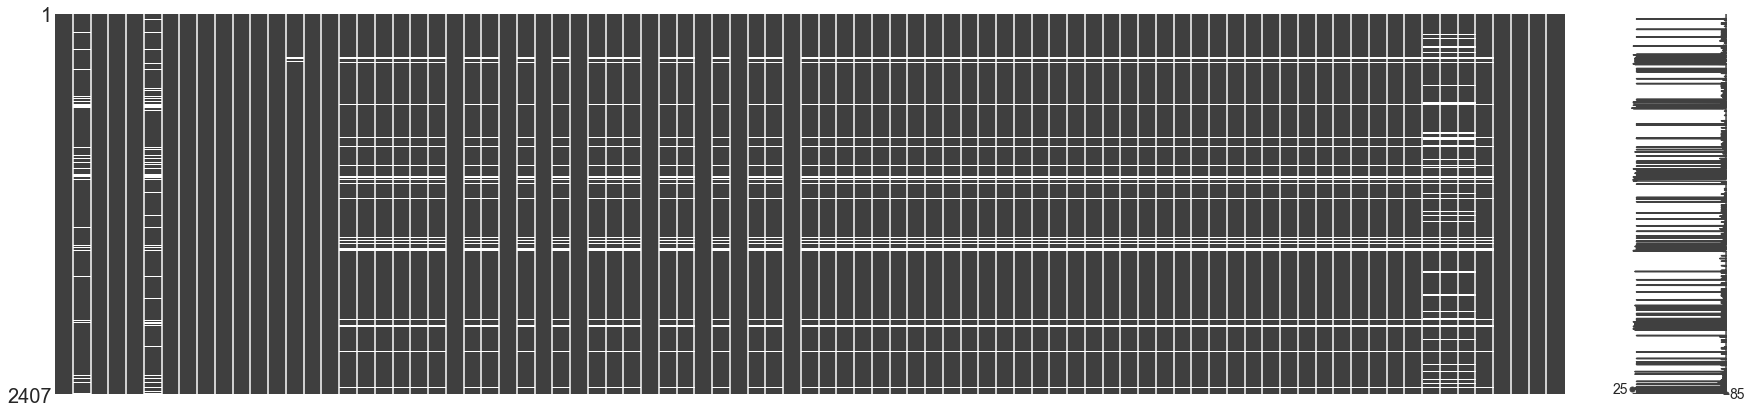

In [23]:
# Plot visualisation of the missing values for each feature of the raw DataFrame, df_wyscout_raw
msno.matrix(df_wyscout_raw, figsize = (30, 7))

In [25]:
# Counts of missing values
null_value_stats = df_wyscout_raw.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

Team                                   137
Contract expires                       260
Foot                                    45
Successful defensive actions per 90    167
Defensive duels per 90                 167
Defensive duels won, %                 167
Aerial duels per 90                    167
Aerial duels won, %                    167
Sliding tackles per 90                 167
Shots blocked per 90                   167
Interceptions per 90                   167
Fouls per 90                           167
Yellow cards per 90                    167
Red cards per 90                       167
Successful attacking actions per 90    167
Goals per 90                           167
Non-penalty goals per 90               167
xG per 90                              167
Head goals per 90                      167
Shots per 90                           167
Shots on target, %                     167
Assists per 90                         167
Crosses per 90                         167
Accurate cr

___

<a id='section6'></a>

## <a id='#section6'>6. Further Data Engineering</a>

<a id='section6.1'></a>

### <a id='#section6.1'>6.1. Assign Raw DataFrame to Engineered DataFrame
From this point, all changes made to the dataset applied to the new engineered DataFrame, `df_wyscout_raw`.

In [26]:
# Assign Raw DataFrame to Engineered DataFrame
df_wyscout = df_wyscout_raw.copy()

# Display DataFrame
df_wyscout.head() 

,Player,Team,Position,Age,Market value,Contract expires,Matches played,Minutes played,Goals,xG,Assists,xA,Birth country,Foot,Height,On loan,Successful defensive actions per 90,Defensive duels per 90,"Defensive duels won, %",Aerial duels per 90,"Aerial duels won, %",Sliding tackles per 90,PAdj Sliding tackles,Shots blocked per 90,Interceptions per 90,PAdj Interceptions,Fouls per 90,Yellow cards,Yellow cards per 90,Red cards,Red cards per 90,Successful attacking actions per 90,Goals per 90,Non-penalty goals,Non-penalty goals per 90,xG per 90,Head goals,Head goals per 90,Shots,Shots per 90,"Shots on target, %","Goal conversion, %",Assists per 90,Crosses per 90,"Accurate crosses, %",Dribbles per 90,"Successful dribbles, %",Offensive duels per 90,"Offensive duels won, %",Touches in box per 90,Progressive runs per 90,Accelerations per 90,Received passes per 90,Fouls suffered per 90,Passes per 90,"Accurate passes, %",Forward passes per 90,"Accurate forward passes, %",Long passes per 90,"Accurate long passes, %",xA per 90,Shot assists per 90,Second assists per 90,Third assists per 90,Smart passes per 90,"Accurate smart passes, %",Key passes per 90,Passes to final third per 90,"Accurate passes to final third, %",Passes to penalty area per 90,"Accurate passes to penalty area, %",Through passes per 90,"Accurate through passes, %",Deep completions per 90,Deep completed crosses per 90,Progressive passes per 90,"Accurate progressive passes, %",Free kicks per 90,Direct free kicks per 90,"Direct free kicks on target, %",Corners per 90,Penalties taken,"Penalty conversion, %",Season,League
0,O. Édouard,Celtic,CF,23,17000000,2022-05-31,31,2409,18,21.75,4,3.88,French Guiana,right,187,no,2.54,1.94,65.38,3.10,39.76,0.07,0.13,0.11,1.20,2.12,0.64,1,0.04,0,0.0,5.60,0.67,13,0.49,0.81,1,0.04,101,3.77,51.49,17.822,0.15,0.78,28.57,6.87,45.11,16.59,31.53,5.53,1.68,0.64,20.10,1.01,25.29,82.13,4.67,68.80,0.26,42.86,0.15,1.12,0.04,0.00,0.86,39.13,0.56,1.34,80.56,2.54,64.71,0.78,38.10,2.02,0.19,1.64,88.64,0.30,0.30,12.5,0.00,6,83.333,20/21,Scottish Premiership
1,R. Kent,Rangers,"LWF, LAMF",24,14000000,2023-05-31,37,3128,10,7.75,8,6.69,England,right,172,no,4.09,3.63,57.14,2.04,12.68,0.03,0.05,0.03,1.99,3.46,0.75,0,0.00,0,0.0,6.70,0.29,10,0.29,0.22,1,0.03,82,2.36,41.46,12.195,0.23,2.45,43.53,7.88,54.74,14.24,42.42,4.11,3.91,2.79,33.69,1.64,44.19,88.02,8.23,79.37,1.44,50.00,0.19,1.64,0.14,0.09,0.72,48.00,0.95,3.65,85.83,3.34,59.48,0.72,40.00,2.01,1.06,4.92,91.23,0.03,0.00,0.0,0.75,0,0.000,20/21,Scottish Premiership
2,M. Elyounoussi,Southampton,"LAMF, CF, AMF",27,12000000,2023-06-30,34,1868,10,10.53,4,2.70,Norway,right,178,no,6.31,5.40,54.46,5.40,48.21,0.29,0.53,0.19,3.08,5.61,1.54,2,0.10,0,0.0,5.20,0.48,10,0.48,0.51,3,0.14,68,3.28,42.65,14.706,0.19,2.17,28.89,5.06,52.38,13.01,37.04,5.01,2.75,1.16,27.37,0.96,35.94,80.03,8.29,67.44,1.59,48.48,0.13,1.25,0.00,0.00,1.20,44.00,0.67,2.46,66.67,3.66,51.32,1.11,34.78,2.17,0.63,3.47,79.17,0.14,0.05,0.0,0.05,0,0.000,20/21,Scottish Premiership
3,A. Morelos,Rangers,CF,25,12000000,2023-05-31,29,2143,12,13.68,3,2.15,Colombia,left,177,no,3.86,3.74,44.94,3.95,28.72,0.25,0.42,0.04,1.93,3.21,1.76,8,0.34,0,0.0,2.69,0.50,12,0.50,0.57,3,0.13,73,3.07,41.10,16.438,0.13,0.80,31.58,2.65,34.92,9.83,33.76,5.46,0.84,0.46,25.45,1.85,32.17,80.42,4.75,65.49,1.13,74.07,0.09,0.76,0.04,0.04,0.55,46.15,0.29,1.89,71.11,1.26,46.67,0.42,40.00,1.26,0.21,2.02,68.75,0.00,0.00,0.0,0.00,0,0.000,20/21,Scottish Premiership
4,J. Frimpong,Bayer Leverkusen,"RB, RWB",20,10000000,2025-06-30,22,1750,1,1.76,1,3.02,Netherlands,right,175,no,6.07,5.19,66.34,3.65,29.58,0.10,0.19,0.10,2.52,4.54,0.31,0,0.00,0,0.0,4.78,0.05,1,0.05,0.09,0,0.00,14,0.72,42.86,7.143,0.05,2.98,18.97,6.84,54.14,11.78,49.34,3.19,7.20,2.73,32.55,2.01,42.84,84.75,10.03,77.95,1.70,54.55,0.16,1.39,0.05,0.05,0.31,66.67,0.51,3.75,82.19,1.95,55.26,0.26,60.00,1.29,0.57,7.61,72.97,0.00,0.00,0.0,0.00,0,0.000,20/21,Scottish Premiership


<a id='section6.2'></a>

### <a id='#section6.2'>6.2. Split Out Positions

In [40]:
df_wyscout[['Primary Position', 'Secondary Position', 'Tertiary Position']] = df_wyscout_raw['Position'].str.split(', ', expand=True)

In [41]:
df_wyscout['Primary Position'] = df_wyscout['Primary Position'].fillna('N/A')
df_wyscout['Secondary Position'] = df_wyscout['Secondary Position'].fillna('N/A')
df_wyscout['Tertiary Position'] = df_wyscout['Tertiary Position'].fillna('N/A')

<a id='section6.3'></a>

### <a id='#section6.3'>6.3. Group Positions

In [42]:
df_wyscout['Primary Position'].unique()

array(['CF', 'LWF', 'LAMF', 'RB', 'RCB', 'LCMF', 'RCMF', 'LCB', 'RWF',
       'RAMF', 'LB', 'AMF', 'DMF', 'CB', 'GK', 'LW', 'RW', 'RWB', 'LDMF',
       'LWB', 'RDMF'], dtype=object)

##### Position

In [43]:
dict_positions_grouped = {'GK': 'Goalkeeper',
                          'LWB': 'Defender',
                          'LB': 'Defender',
                          'LCB': 'Defender',
                          'CB': 'Defender',
                          'RCB': 'Defender',
                          'RB': 'Defender',
                          'RWB': 'Defender',
                          'LDMF': 'Midfielder',
                          'DMF': 'Midfielder',
                          'RDMF': 'Midfielder',
                          'LCMF': 'Midfielder',
                          'RCMF': 'Midfielder',
                          'LAMF': 'Midfielder',
                          'AMF': 'Midfielder',
                          'RAMF': 'Midfielder',
                          'LWF': 'Forward',
                          'RWF': 'Forward',
                          'LW': 'Forward',
                          'RW': 'Forward',
                          'CF': 'Forward',
                          'N/A': 'N/A'
                         }

In [44]:
# Map grouped positions to DataFrame
df_wyscout['Primary Position Grouped'] = df_wyscout['Primary Position'].map(dict_positions_grouped)
df_wyscout['Secondary Position Grouped'] = df_wyscout['Secondary Position'].map(dict_positions_grouped)
df_wyscout['Tertiary Position Grouped'] = df_wyscout['Tertiary Position'].map(dict_positions_grouped)

##### Goalkeeper / Outfielder

In [45]:
# Separate Goalkeeper and Outfielders
df_wyscout['Outfielder Goalkeeper'] = np.where(df_wyscout['Primary Position Grouped'] == 'Goalkeeper', 'Goalkeeper', 'Outfielder')

In [52]:
df_wyscout

,Player,Team,Position,Age,Market Value (EUR),Contract expires,Matches played,Minutes played,Goals,xG,Assists,xA,Birth country,Foot,Height,On loan,Successful defensive actions per 90,Defensive duels per 90,"Defensive duels won, %",Aerial duels per 90,"Aerial duels won, %",Sliding tackles per 90,PAdj Sliding tackles,Shots blocked per 90,Interceptions per 90,PAdj Interceptions,Fouls per 90,Yellow cards,Yellow cards per 90,Red cards,Red cards per 90,Successful attacking actions per 90,Goals per 90,Non-penalty goals,Non-penalty goals per 90,xG per 90,Head goals,Head goals per 90,Shots,Shots per 90,"Shots on target, %","Goal conversion, %",Assists per 90,Crosses per 90,"Accurate crosses, %",Dribbles per 90,"Successful dribbles, %",Offensive duels per 90,"Offensive duels won, %",Touches in box per 90,Progressive runs per 90,Accelerations per 90,Received passes per 90,Fouls suffered per 90,Passes per 90,"Accurate passes, %",Forward passes per 90,"Accurate forward passes, %",Long passes per 90,"Accurate long passes, %",xA per 90,Shot assists per 90,Second assists per 90,Third assists per 90,Smart passes per 90,"Accurate smart passes, %",Key passes per 90,Passes to final third per 90,"Accurate passes to final third, %",Passes to penalty area per 90,"Accurate passes to penalty area, %",Through passes per 90,"Accurate through passes, %",Deep completions per 90,Deep completed crosses per 90,Progressive passes per 90,"Accurate progressive passes, %",Free kicks per 90,Direct free kicks per 90,"Direct free kicks on target, %",Corners per 90,Penalties taken,"Penalty conversion, %",Season,League,Primary Position,Secondary Position,Tertiary Position,Primary Position Grouped,Secondary Position Grouped,Outfielder Goalkeeper,Tertiary Position Grouped,Market Value (GBP)
0,O. Édouard,Celtic,CF,23,17000000,2022-05-31,31,2409,18,21.75,4,3.88,French Guiana,right,187,no,2.54,1.94,65.38,3.10,39.76,0.07,0.13,0.11,1.20,2.12,0.64,1,0.04,0,0.0,5.60,0.67,13,0.49,0.81,1,0.04,101,3.77,51.49,17.822,0.15,0.78,28.57,6.87,45.11,16.59,31.53,5.53,1.68,0.64,20.10,1.01,25.29,82.13,4.67,68.80,0.26,42.86,0.15,1.12,0.04,0.00,0.86,39.13,0.56,1.34,80.56,2.54,64.71,0.78,38.10,2.02,0.19,1.64,88.64,0.30,0.30,12.5,0.00,6,83.333,20/21,Scottish Premiership,CF,N/A,N/A,Forward,N/A,Outfielder,N/A,15300000.0
1,R. Kent,Rangers,"LWF, LAMF",24,14000000,2023-05-31,37,3128,10,7.75,8,6.69,England,right,172,no,4.09,3.63,57.14,2.04,12.68,0.03,0.05,0.03,1.99,3.46,0.75,0,0.00,0,0.0,6.70,0.29,10,0.29,0.22,1,0.03,82,2.36,41.46,12.195,0.23,2.45,43.53,7.88,54.74,14.24,42.42,4.11,3.91,2.79,33.69,1.64,44.19,88.02,8.23,79.37,1.44,50.00,0.19,1.64,0.14,0.09,0.72,48.00,0.95,3.65,85.83,3.34,59.48,0.72,40.00,2.01,1.06,4.92,91.23,0.03,0.00,0.0,0.75,0,0.000,20/21,Scottish Premiership,LWF,LAMF,N/A,Forward,Midfielder,Outfielder,N/A,12600000.0
2,M. Elyounoussi,Southampton,"LAMF, CF, AMF",27,12000000,2023-06-30,34,1868,10,10.53,4,2.70,Norway,right,178,no,6.31,5.40,54.46,5.40,48.21,0.29,0.53,0.19,3.08,5.61,1.54,2,0.10,0,0.0,5.20,0.48,10,0.48,0.51,3,0.14,68,3.28,42.65,14.706,0.19,2.17,28.89,5.06,52.38,13.01,37.04,5.01,2.75,1.16,27.37,0.96,35.94,80.03,8.29,67.44,1.59,48.48,0.13,1.25,0.00,0.00,1.20,44.00,0.67,2.46,66.67,3.66,51.32,1.11,34.78,2.17,0.63,3.47,79.17,0.14,0.05,0.0,0.05,0,0.000,20/21,Scottish Premiership,LAMF,CF,AMF,Midfielder,Forward,Outfielder,Midfielder,10800000.0
3,A. Morelos,Rangers,CF,25,12000000,2023-05-31,29,2143,12,13.68,3,2.15,Colombia,left,177,no,3.86,3.74,44.94,3.95,28.72,0.25,0.42,0.04,1.93,3.21,1.76,8,0.34,0,0.0,2.69,0.50,12,0.50,0.57,3,0.13,73,3.07,41.10,16.438,0.13,0.80,31.58,2.65,34.92,9.83,33.76,5.46,0.84,0.46,25.45,1.85,32.17,80.42,4.75,65.49,1.13,74.07,0.09,0.76,0.04,0.04,0.55,46.15,0.29,1.89,71.11,1.26,46.67,0.42,40.00,1.26,0.21,2.02,68.75,0.00,0.00,0.0,0.00,0,0.000,20/21,Scottish Premiership,CF,N/A,N/A,Forward,N/A,Outfielder,N/A,10800000.0
4,J. Frimpong,Bayer Leverkusen,"RB, RWB",20,10000000,2025-06-30,22,1750,1,1.76,1,3.02,Netherlands,right,175,no,6.07,5.19,66.34,3.65,29.58,0.10,0.1

<a id='section6.4'></a>

### <a id='#section6.4'>6.4. Convert Market Value to Pounds

In [49]:
# Rename columns
df_wyscout = df_wyscout.rename(columns={'Market value': 'Market Value (EUR)'})

In [53]:
rate_eur_gbp = 0.9

df_wyscout['Market Value (GBP)'] = df_wyscout['Market Value (EUR)'] * rate_eur_gbp

<a id='section6.5'></a>

### <a id='#section6.5'>6.5. Export Engineered Dataset</a>

In [54]:
# Export DataFrame

##
df_wyscout.to_csv(os.path.join(data_dir_wyscout, 'engineered/aggregated/wyscout_scotland_2bundesliga_belgium_1920_2021.csv'), index=None, header=True)

##
df_wyscout.to_csv(os.path.join(data_dir, 'export/wyscout_aggregated_scotland_2bundesliga_belgium_1920_2021.csv'), index=None, header=True)

___

<a id='section7'></a>

## <a id='#section7'>7. Summary</a>
This notebook scrapes player performance data from [Wyscout](https://wyscout.com/) using [pandas](http://pandas.pydata.org/) for data manipulation through DataFrames.

___

<a id='section8'></a>

## <a id='#section8'>8. Next Steps</a>
This data is now ready to be exported and visualised in Tableau.

---

***Visit my website [eddwebster.com](https://www.eddwebster.com) or my [GitHub Repository](https://github.com/eddwebster) for more projects. If you'd like to get in contact, my Twitter handle is [@eddwebster](http://www.twitter.com/eddwebster) and my email is: edd.j.webster@gmail.com.***

[Back to the top](#top)